In [5]:
notebook_mode = True
viz_mode = False

In [6]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available. GPU can be used.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. GPU cannot be used.")


CUDA is not available. GPU cannot be used.


# Import packages

In [44]:
import os
import json
import argparse
import time
import random

import numpy as np
import csv

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter  # tensorboardXの代替

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore")
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.exact_solution import SolveExactSolution
from utils.flow import Flow
from utils.data_maker import DataMaker
from utils.dataset_reader import DatasetReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

# Setting for notebook

In [10]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

# Load configurations

In [11]:
config_path = "configs/default.json"

config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/default.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'graph_filepath': './data/graph.gml', 'edge_numbering_filepath': './data/edge_numbering_file.csv', 'train_filepath': './data/gragh.gml', 'val_filepath': './data/tsp10_val_concorde.txt', 'test_filepath': './data/tsp10_test_concorde.txt', 'solver_type': 'pulp', 'graph_model': 'nsfnet', 'num_data': 50, 'num_nodes': 14, 'num_neighbors': 5, 'num_commodities': 10, 'sample_size': 5, 'capacity_lower': 500, 'capacity_higher': 1000, 'demand_lower': 1, 'demand_higher': 500, 'node_dim': 10, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 10, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 10, 'val_every': 5, 'test_every': 10, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


# Configure GPU options

In [12]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id) 

if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.float
    dtypeLong = torch.long
    torch.manual_seed(1)

CUDA not available


# Make graph dataset
gragh.gmlとedge_numbering_file.csvの作成

In [13]:
num_data = config.num_data
solver_type = config.solver_type
Maker = DataMaker(config)
exact_file_name ="./data/exact_solution.csv"
infinit_loop_count = 0
incorrect_value_count = 0

for data in range(num_data):
    if data % 10 == 0:
        print(data, " data was created.")
    # ディレクトリ番号の定義
    file_number = data - (data % 10)
    
    # ディレクトリの作成
    graph_file_directory = "./data/graph_file/{}".format(file_number)
    if not os.path.exists(graph_file_directory):
        os.makedirs(graph_file_directory)
    commodity_file_directory = "./data/commodity_file/{}".format(file_number)
    if not os.path.exists(commodity_file_directory):
        os.makedirs(commodity_file_directory)
    edge_file_directory = "./data/edge_file/{}".format(file_number)
    if not os.path.exists(edge_file_directory):
        os.makedirs(edge_file_directory)
    node_flow_file_directory = "./data/node_flow_file/{}".format(file_number)
    if not os.path.exists(node_flow_file_directory):
        os.makedirs(node_flow_file_directory)
    edge_flow_file_directory = "./data/edge_flow_file/{}".format(file_number)
    if not os.path.exists(edge_flow_file_directory):
        os.makedirs(edge_flow_file_directory)

    # ファイル名の定義
    graph_file_name = "./data/graph_file/{file_number}/graph_{data}.gml".format(file_number=file_number, data=data)
    comodity_file_name = "./data/commodity_file/{file_number}/commodity_data_{data}.csv".format(file_number=file_number, data=data)
    edge_file_name = "./data/edge_file/{file_number}/edge_numbering_{data}.csv".format(file_number=file_number, data=data)
    node_flow_file_name = "./data/node_flow_file/{file_number}/node_flow_{data}.csv".format(file_number=file_number, data=data)
    edge_flow_file_name = "./data/edge_flow_file/{file_number}/edge_flow_{data}.csv".format(file_number=file_number, data=data)

    # 作成したdataが適切で無い場合のやり直し
    while True:
    # グラフ作成
        G = Maker.create_graph()
        
        # 品種作成
        commodity_list = Maker.generate_commodity()
        
        # グラフの保存
        nx.write_gml(G, graph_file_name)

        # 品種の保存
        with open((comodity_file_name), 'w') as f:
            writer = csv.writer(f, lineterminator='\n')
            writer.writerows(commodity_list)

        # 厳密解の計算
        E = SolveExactSolution(solver_type, comodity_file_name, graph_file_name)
        flow_var_kakai, edge_list, objective_value, elapsed_time = E.solve_exact_solution_to_env()
        node_flow_matrix, edge_flow_matrix, infinit_loop = E.generate_flow_matrices(flow_var_kakai)
        
        # 厳密解が1以上、または厳密解のフローが正しく導けなかった場合のやり直し
        if infinit_loop:
            infinit_loop_count += 1
        elif objective_value >= 1.0:
            incorrect_value_count += 1
        else:
            break
    
    # エッジの保存
    with open(edge_file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        for item in edge_list:
            writer.writerow([item[0], item[1][0], item[1][1]])
    
    # 厳密解の保存
    with open(exact_file_name, 'a', newline='') as f:
        out = csv.writer(f)
        out.writerow([objective_value,elapsed_time]) 

    # 厳密解のノードのフローの保存
    with open(node_flow_file_name, mode="w", newline="") as file:
        writer = csv.writer(file)
        for row in node_flow_matrix:
            writer.writerow(row)
    # 厳密解のエッジのフローの保存
    with open(edge_flow_file_name, mode="w", newline="") as file:
        writer = csv.writer(file)
        for row in edge_flow_matrix:
            writer.writerow(row)


0  data was created.
10  data was created.
20  data was created.
30  data was created.
40  data was created.


# Test data loading

Number of batches of size 20: 2
Batch generation took: 0.150 sec
edges: (20, 14, 14)
edges_capacity: (20, 14, 14)
edges_targets: (20, 14, 14, 10)
nodes: (20, 14, 10)
nodes_target: (20, 10, 14)
load_factor: (20,)


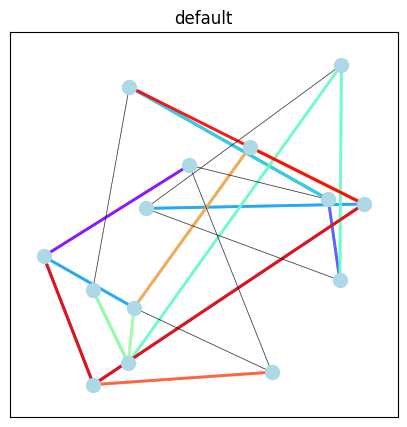

In [47]:
if notebook_mode:
    num_data = config.num_data
    batch_size = config.batch_size
    #　DataMakerを繰り返し呼び出しバッチごとにtensorを生成する
    dataset = DatasetReader(num_data, batch_size)
    print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

    t = time.time()
    batch = next(iter(dataset))  # Generate a batch of TSPs
    print("Batch generation took: {:.3f} sec".format(time.time() - t))
    print("edges:", batch.edges.shape)
    print("edges_capacity:", batch.edges_capacity.shape)
    print("edges_targets:", batch.edges_target.shape)
    print("nodes:", batch.nodes.shape)
    print("nodes_target:", batch.nodes_target.shape)
    print("load_factor:", batch.load_factor.shape)

    idx = 0
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_uelb(a, batch.edges[idx], batch.edges_target[idx])